In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
import os
%matplotlib inline

In [2]:
from keras.preprocessing import image
from keras.losses import binary_crossentropy ## loss function

Using TensorFlow backend.


In [3]:
from helper import *
from unet import *

In [4]:
### GPU memory setup
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [5]:
### detect GPU
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [6]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None,input_size = (224,224,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    #model.summary()

    return model

### parameters

In [8]:
BACKBONE = "naive_unet"

dir_path = "../data/sample_data/"
outdir_path = "../result/miniBatch/naive_unet"

seed = 1

# data augmentation parameters
data_gen_args = dict(#rescale=1./255,
                     rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range = 0.05,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

# model trainig
EPOCHS = 20
BATCH_SIZE = 8

### load data

In [9]:
## load data
x_train = load_image_from_folder(dir_path + "train_image")
y_train = load_image_from_folder(dir_path + "train_mask")
x_test =load_image_from_folder(dir_path + "validate_image")
y_test =load_image_from_folder(dir_path + "validate_mask")

### turn mask into non-RGB, binary
y_train = y_train.mean(axis=3)/255
y_test = y_test.mean(axis=3)/255

### reshape to tensor
y_train = y_train.reshape((-1, 224, 224,1))
y_test = y_test.reshape((-1, 224, 224,1))

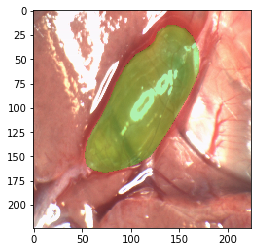

In [7]:
### visualize image/mask overlay
#plt.imshow(mask_overlay(x_train[0], y_train[0]*255, img_format = "image"))

- binary segmentation

### data augmentation

In [10]:
image_datagen = image.ImageDataGenerator(**data_gen_args)
mask_datagen = image.ImageDataGenerator(**data_gen_args)

### no standardization, no fit
#image_datagen.fit(x_train, augment=True, seed=seed)
#mask_datagen.fit(y_train, augment=True, seed=seed)


image_generator = image_datagen.flow(x_train, batch_size=BATCH_SIZE, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=BATCH_SIZE, seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## train model

In [11]:
# prepare model
model = unet()
model.compile('Adam', loss = customLoss, metrics = ['binary_accuracy', jaccard, dice])

# train model
history = model.fit_generator(
                    train_generator,
                    validation_data=(x_test,y_test),
                    epochs = EPOCHS,
                    steps_per_epoch = np.floor(len(x_train)/(BATCH_SIZE)),
                    verbose = 1)

/home/zl59/insight/GbSegment/SegmentZoo/segmentzoo_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/20
7/7 [==============================] - 12s 2s/step - loss: 11.8773 - binary_accuracy: 0.4338 - jaccard: 0.0805 - dice: 0.1351 - val_loss: 14.8437 - val_binary_accuracy: 0.0619 - val_jaccard: 0.1394 - val_dice: 0.2439
Epoch 2/20
7/7 [==============================] - 5s 721ms/step - loss: 14.0241 - binary_accuracy: 0.0449 - jaccard: 0.1886 - dice: 0.3117 - val_loss: 15.2943 - val_binary_accuracy: 0.0354 - val_jaccard: 0.1355 - val_dice: 0.2380
Epoch 3/20
7/7 [==============================] - 3s 444ms/step - loss: 13.5469 - binary_accuracy: 0.0317 - jaccard: 0.2209 - dice: 0.3558 - val_loss: 15.3757 - val_binary_accuracy: 0.0306 - val_jaccard: 0.1349 - val_dice: 0.2370
Epoch 4/20
7/7 [==============================] - 3s 443ms/step - loss: 13.9057 - binary_accuracy: 0.0288 - jaccard: 0.2052 - dice: 0.3338 - val_loss: 15.4407 - val_binary_accuracy: 0.0268 - val_jaccard: 0.1343 - val_dice: 0.2362
Epoch 5/20
7/7 [==============================] - 3s 443ms/step - loss: 14.3491 - 

In [12]:
### save training log
RESULT_NAME = BACKBONE + "_batch" + str(BATCH_SIZE)
pd.DataFrame.from_dict(data=history.history).to_csv(outdir_path + RESULT_NAME + "_history.csv")

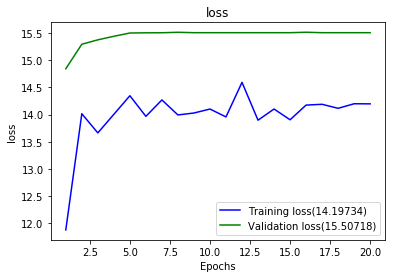

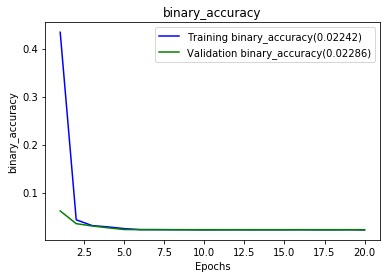

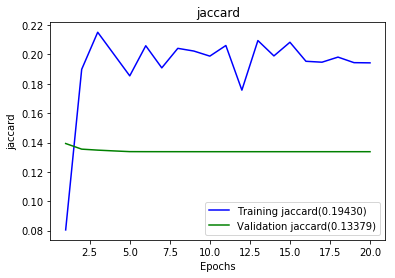

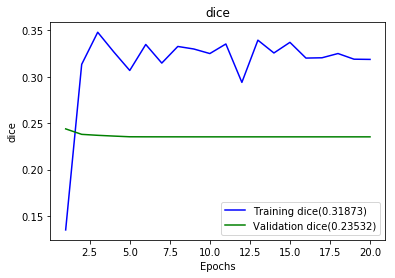

In [14]:
# plot training log
for key in ['loss', 'binary_accuracy','jaccard', 'dice']:
    plot_history(history, key = key)

In [30]:
#model.save_weights(outdir_path + RESULT_NAME + ".h5")

## test on new image

In [17]:
test = load_image_from_folder(dir_path + "test_image")

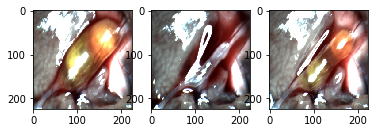

In [19]:
# model result
ypred = model.predict(test)

## plot overlay
for i in range(len(test)):
    plt.subplot(1, len(test), i+1)
    plt.imshow(mask_overlay(test[i,:,:,:], (ypred[i] > 0.5).astype(int) * 255))
plt.savefig(outdir_path + "test_merge.jpg")

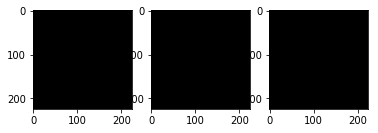

In [20]:
## plot mask
for i in range(len(test)):
    plt.subplot(1, len(test), i+1)
    plt.imshow(np.dstack((ypred[i], ypred[i], ypred[i])))
#plt.savefig(outdir_path + "test_mask.jpg")

### test on training data
- fisrt training data

In [25]:
# model result
ypred = model.predict(x_train[0].reshape(1,224,224,3))

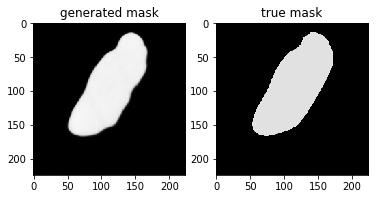

In [26]:
## ypred
plt.subplot(121)
plt.title("generated mask")
plt.imshow(np.dstack((ypred[0], ypred[0], ypred[0])))

## ytrue
plt.subplot(122)
plt.title("true mask")
plt.imshow(np.dstack((y_train[0],y_train[0],y_train[0])))

#plt.savefig(outdir_path + "train_mask.jpg")

### test on real world picture

In [40]:
real = load_image_from_folder(dir_path + "real_image")

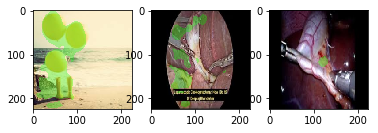

In [41]:
# model result
ypred = model.predict(preprocessing_fn(real))

## plot overlay
for i in range(len(test)):
    plt.subplot(1, len(test), i+1)
    plt.imshow(mask_overlay(real[i,:,:,:], (ypred[i] > 0.5).astype(int) * 255))

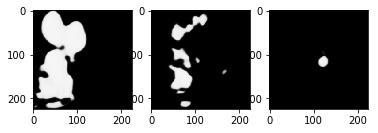

In [42]:
## plot mask
for i in range(len(real)):
    plt.subplot(1, len(real), i+1)
    plt.imshow(np.dstack((ypred[i], ypred[i], ypred[i])))